# Setting up

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# load data
data = pd.read_csv('fake_job_postings.csv')

In [3]:
# drop job id column
data.drop('job_id', axis=1, inplace=True)

In [4]:
# view data
data

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


# EDA
### Exploratory data analysis 
https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data \
The link above is for exploring textual data, so please use these methods on the company_profile, description, requirements, and benefits columns
https://www.geeksforgeeks.org/exploratory-data-analysis-in-python/ \
Can use this link for eda on other columns, but feel free to use other websites or perform eda how you would like 

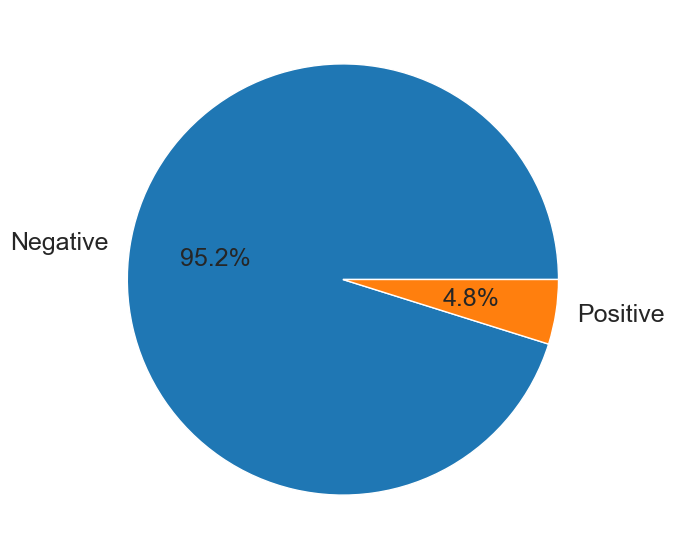

In [6]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

data['fraudulent'].value_counts()
def fraudulents(fraudulent):
    if fraudulent==1:
        return "Positive"
    if fraudulent==0:
        return "Negative"
data['fraudulent'] = data['fraudulent'].apply(fraudulents)
plt.pie(data['fraudulent'].value_counts(), labels=data['fraudulent'].unique().tolist(), autopct='%1.1f%%')
plt.show()

company_profile

Length of a sample review: 885
Word count in a sample review: 141



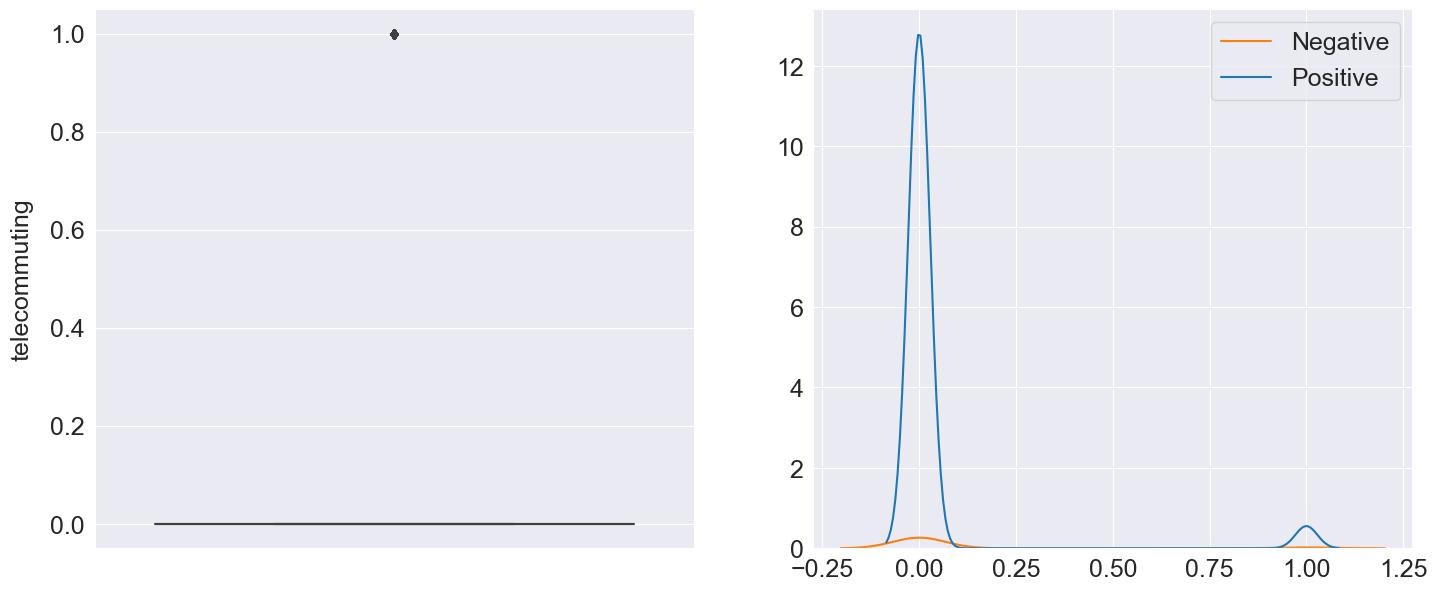

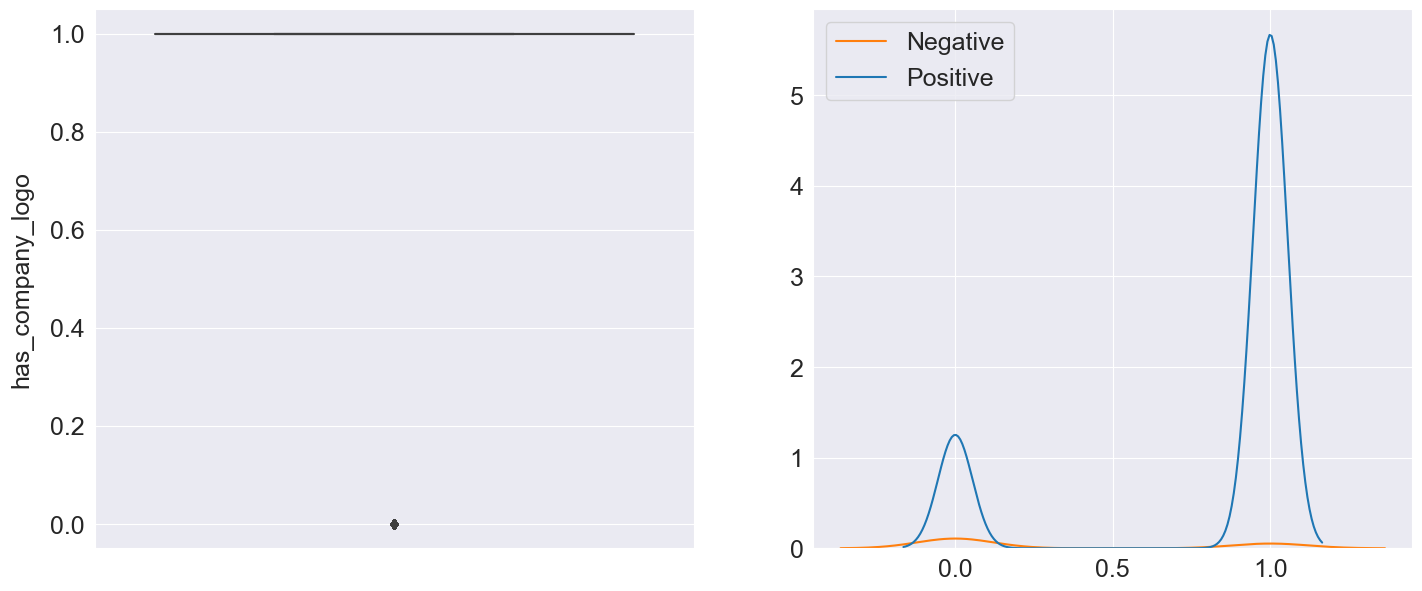

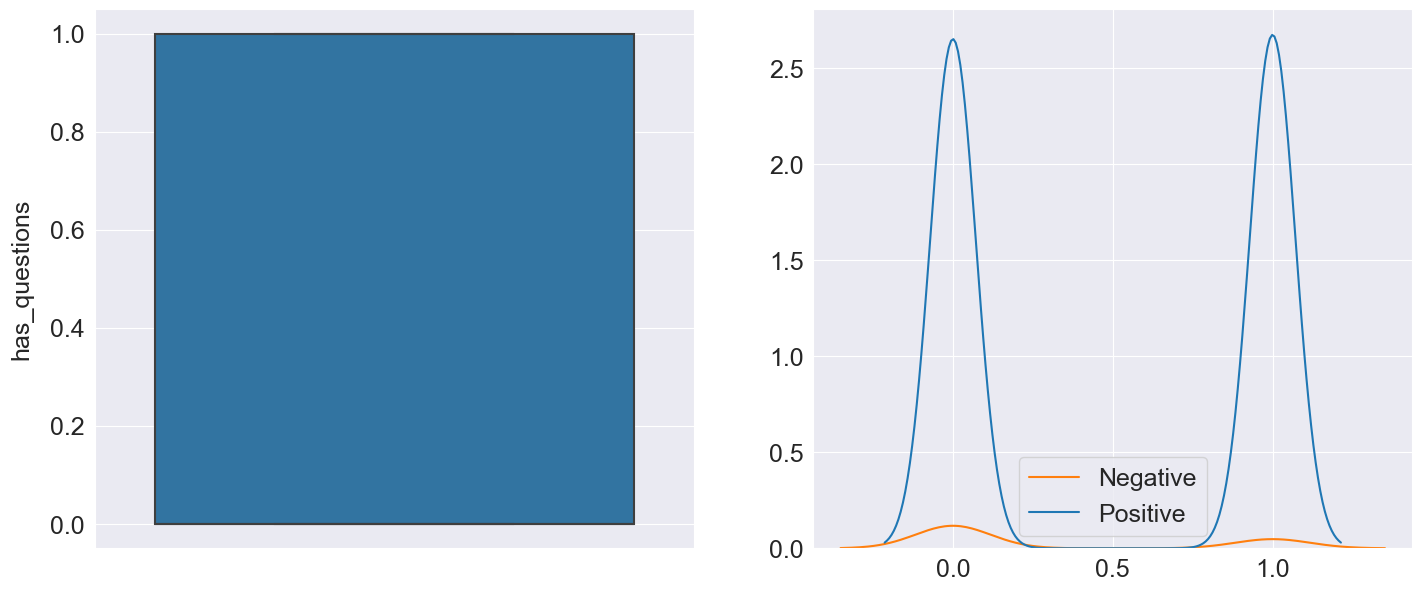

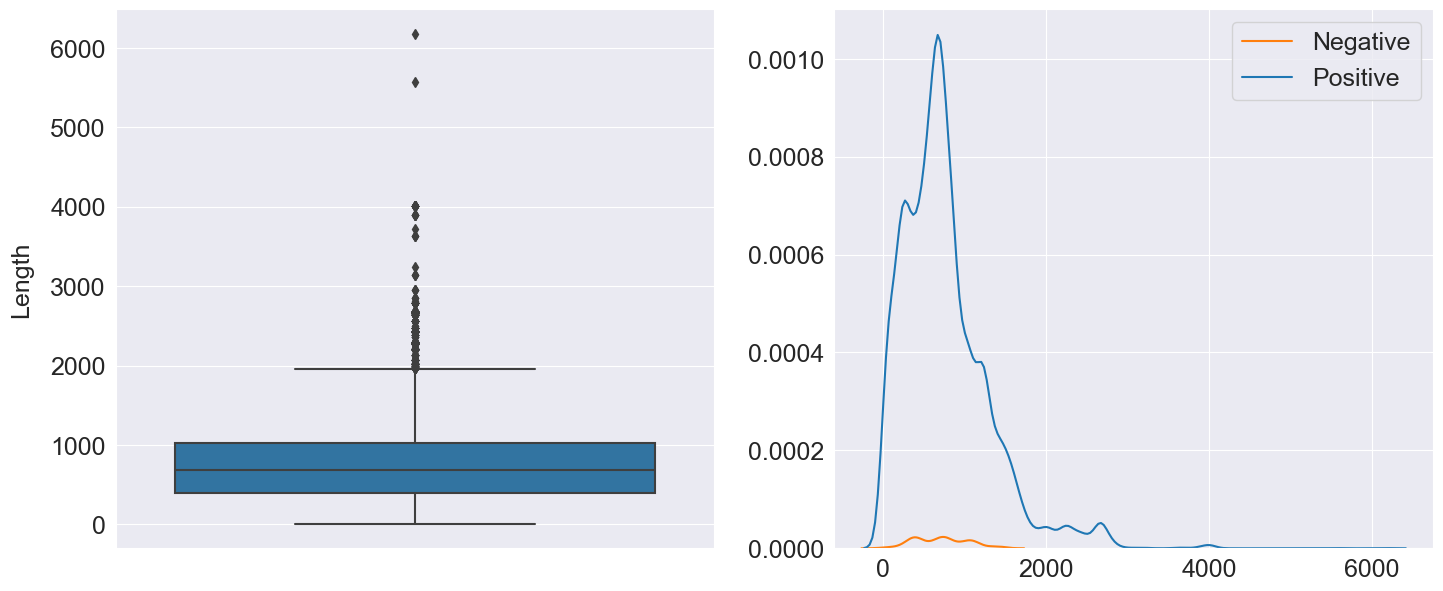

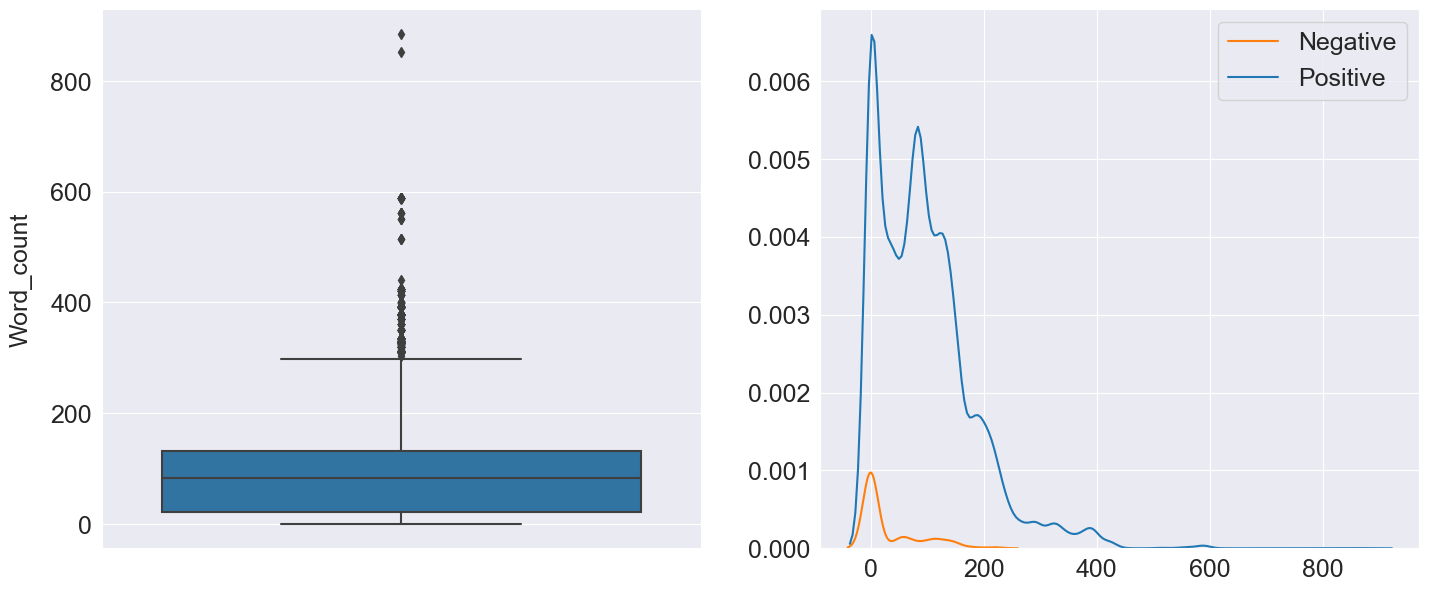

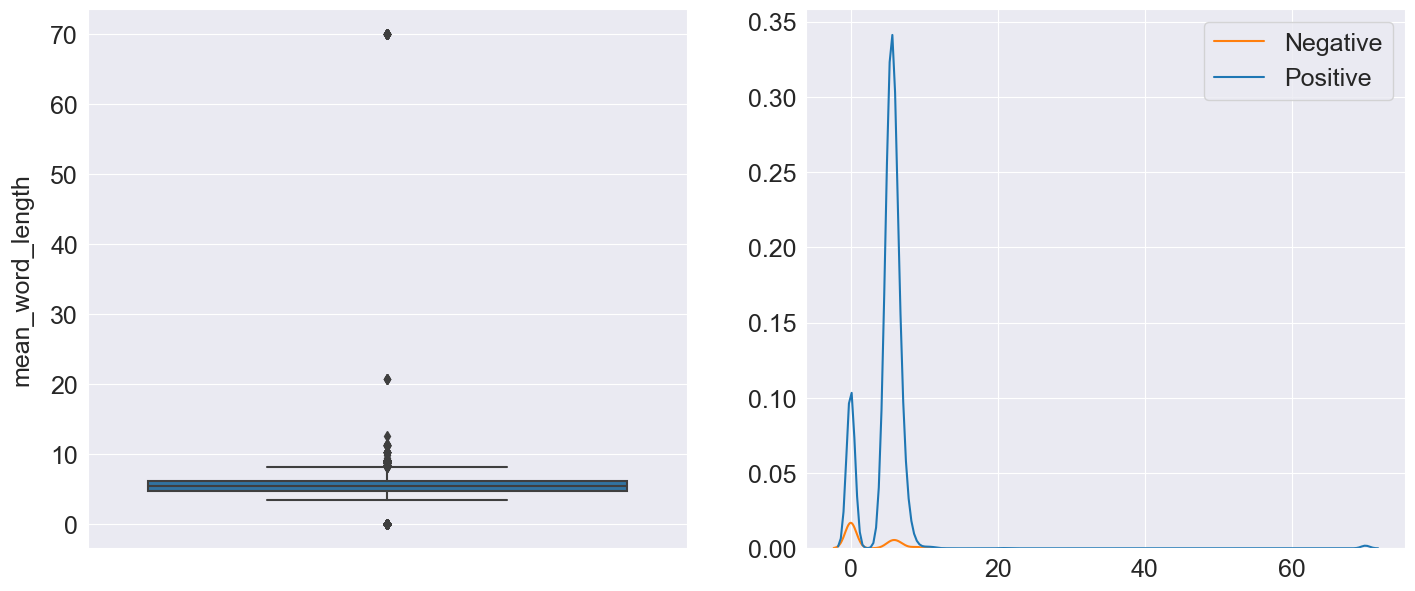

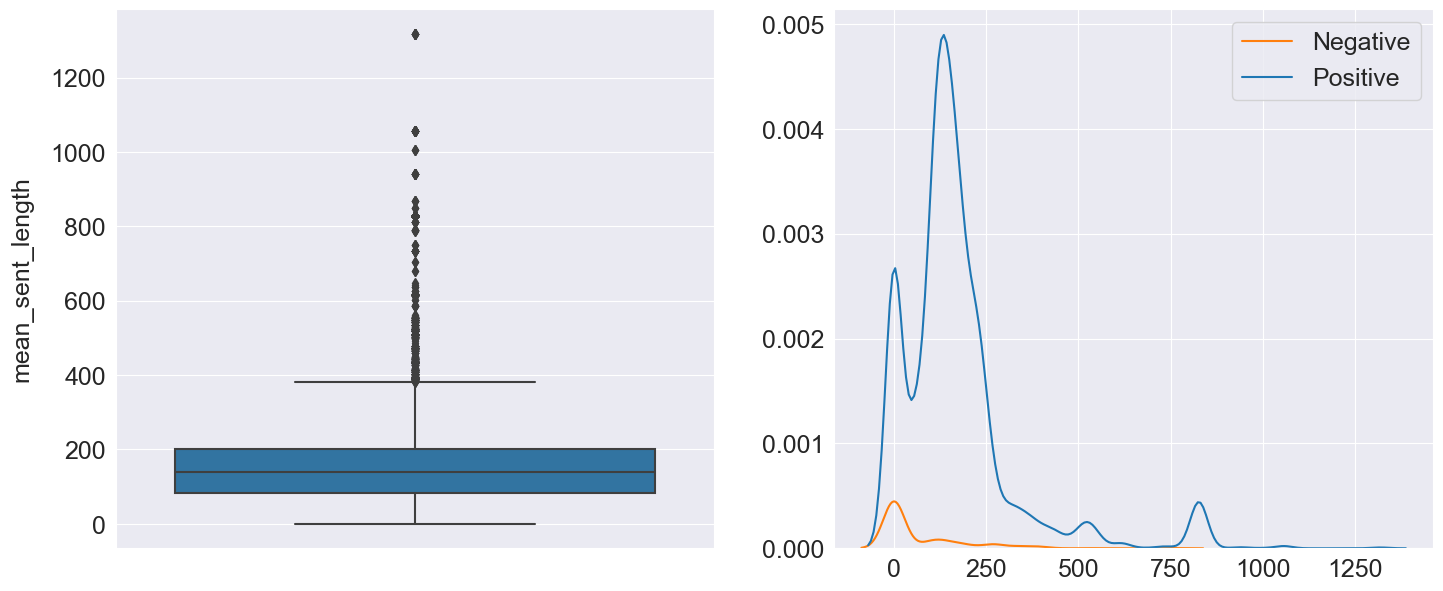

In [6]:
length = len(data['company_profile'][0])
print(f'Length of a sample review: {length}')
data['Length'] = data['company_profile'].str.len()

word_count = data['company_profile'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

def word_count(review):
    if isinstance(review, str):
        company_profile_list = review.split()
        return len(company_profile_list)
    else:
        return 0

data['Word_count'] = data['company_profile'].apply(word_count)
data['mean_word_length'] = data['company_profile'].map(
    lambda rev: np.mean([len(word) for word in rev.split()]) if isinstance(rev, str) else 0
)
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['company_profile'][0])])
data['mean_sent_length'] = data['company_profile'].map(
    lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]) if isinstance(rev, str) else 0
)
data.head(10)

def visualize(col):
    print()
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], hue=data['fraudulent'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    
    # Melt data to long format for kdeplot
    melted_data = data.melt(id_vars='fraudulent', value_vars=[col], var_name='feature', value_name='value')
    sns.kdeplot(data=melted_data, x='value', hue='fraudulent')
    
    plt.legend(data['fraudulent'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

numeric_features = [col for col in data.columns.tolist()[2:] if data[col].dtype.kind in ('i', 'f')]
for feature in numeric_features:
    visualize(feature)

In [29]:
df = data.drop(numeric_features, axis=1)
def clean(review):
    if not isinstance(review, str):
        return ""

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review
df['company_profile'] = df['company_profile'].apply(clean)
df.head(10)
df['company_profile'][0]
def corpus(text):
    text_list = text.split()
    return text_list
df['company_profile'] = df['company_profile'].apply(corpus)
df.head(10)

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"[food52, weve, created, groundbreaking, award-...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,Negative
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"[90, seconds, worlds, cloud, video, production...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,Negative
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,"[valor, services, provides, workforce, solutio...","Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,Negative
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,"[passion, improving, quality, life, geography,...",THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,Negative
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,"[spotsource, solutions, llc, global, human, ca...",JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,Negative
5,Accounting Clerk,"US, MD,",NaN,NaN,[],Job OverviewApex is an environmental consultin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Negative
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"[founded, 2009, thefonpit, agrose, internation...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,Negative
7,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,"[airenvys, mission, provide, lucrative, yet, h...",Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,NaN,NaN,NaN,NaN,NaN,Negative
8,HP BSM SME,"US, FL, Pensacola",NaN,NaN,"[solutions3, woman-owned, small, business, who...",Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,Full-time,Associate,NaN,Information Technology and Services,NaN,Negative
9,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"[novitex, enterprise, solutions, formerly, pit...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,Negative


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17880/17880 [00:00<00:00, 128485.05it/s]


Length of corpus: 1008351


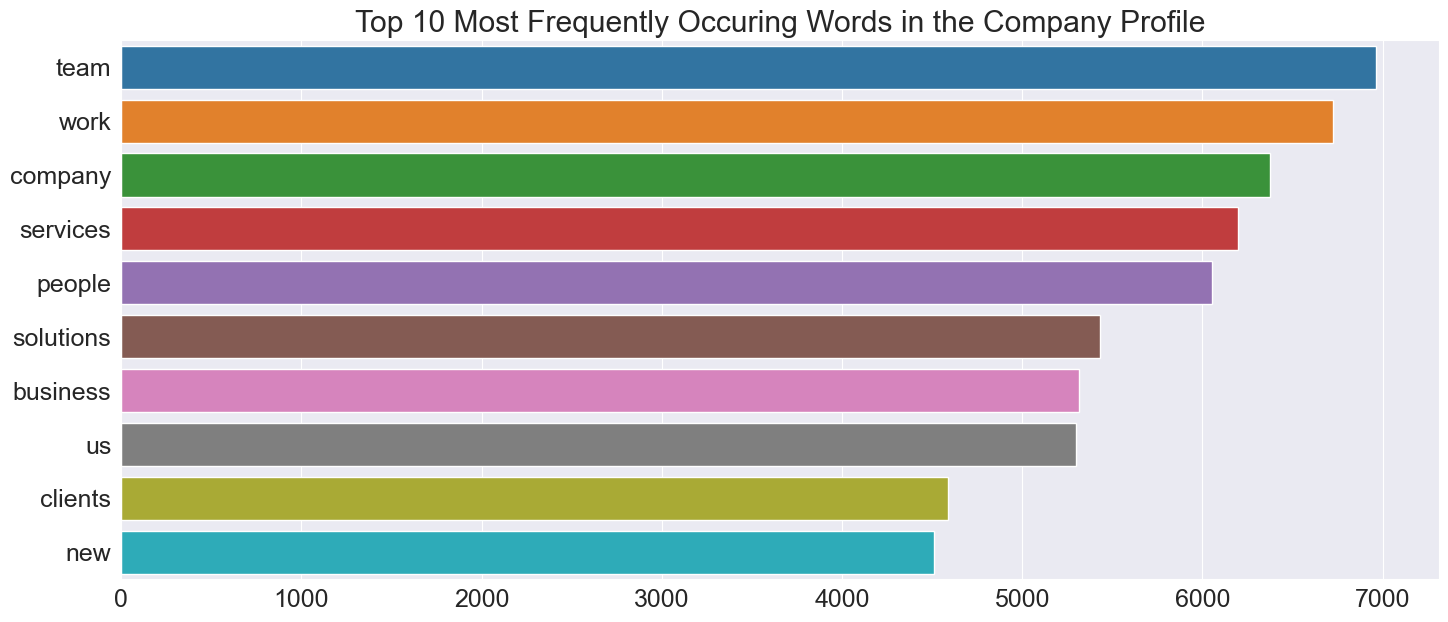

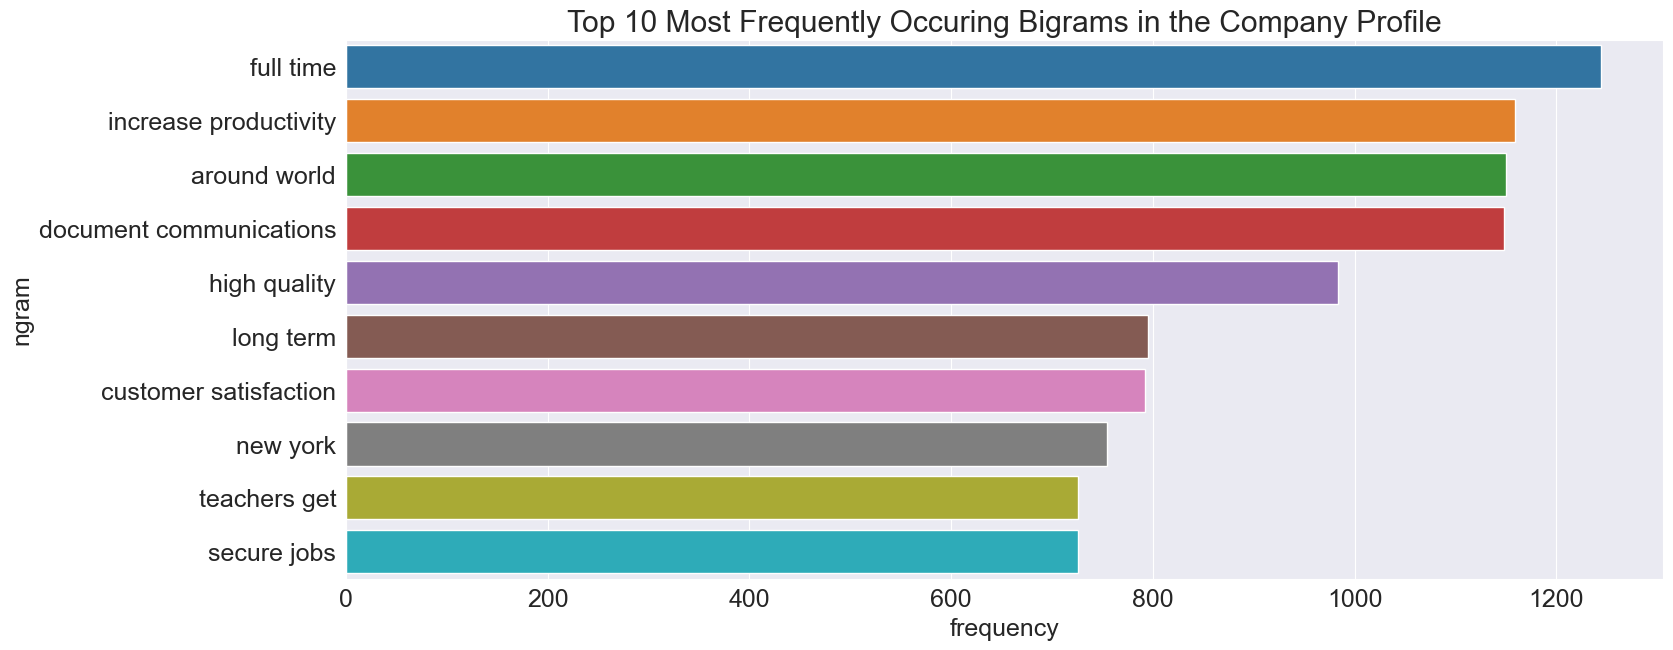

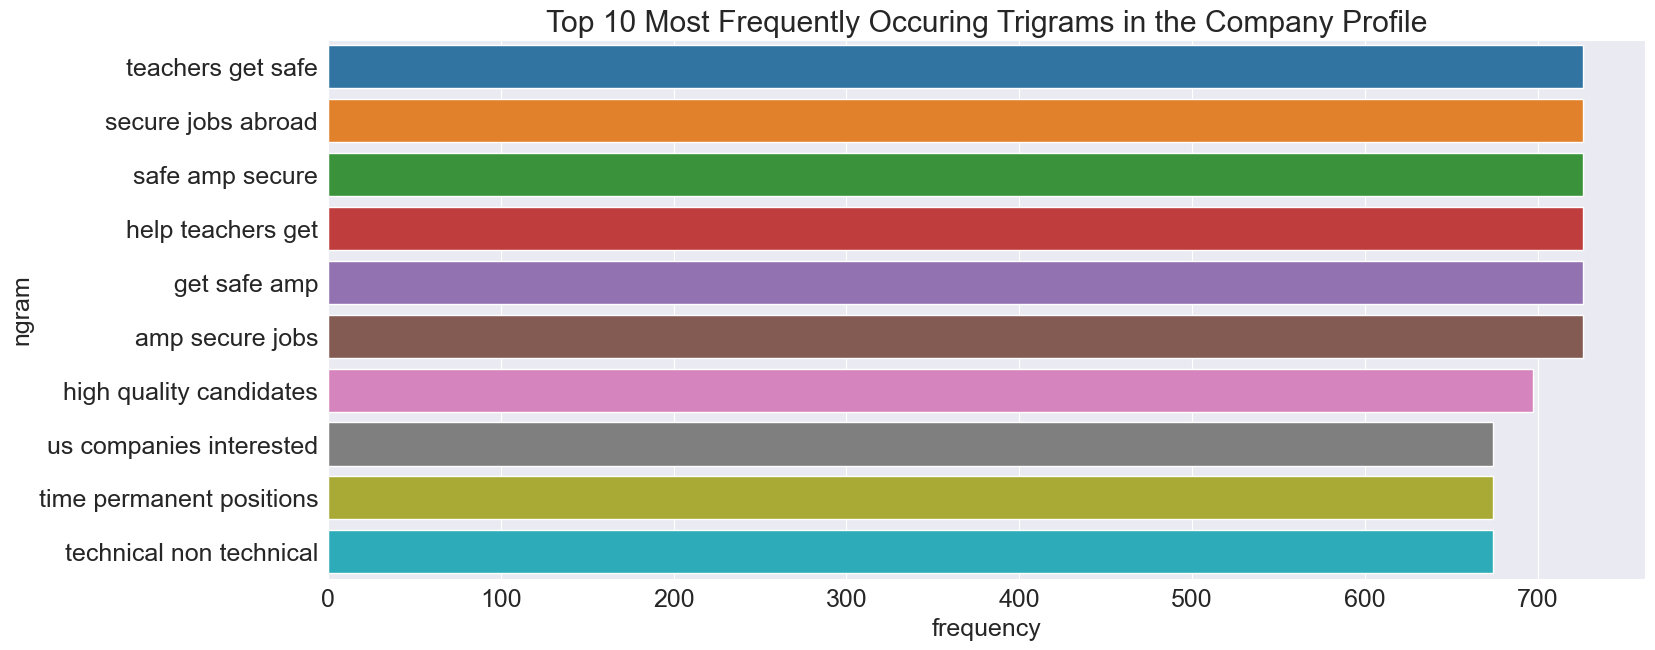

In [30]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['company_profile'][i]
print(f"Length of corpus: {len(corpus)}")

mostCommon = Counter(corpus).most_common(10)
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words in the Company Profile')
plt.show()

# Check if the data is already in the correct format, if not, convert it
if isinstance(df['company_profile'].iloc[0], list):
    df['company_profile'] = [' '.join(map(str, l)) for l in df['company_profile']]

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['company_profile'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams in the Company Profile')
plt.show()

cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['company_profile'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams in the Company Profile')
plt.show()

description

Length of a sample review: 905
Word count in a sample review: 124


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


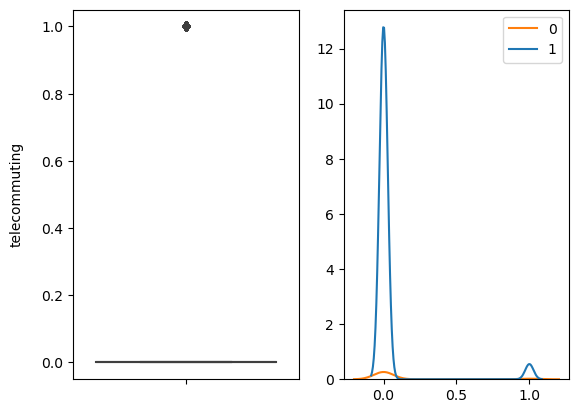

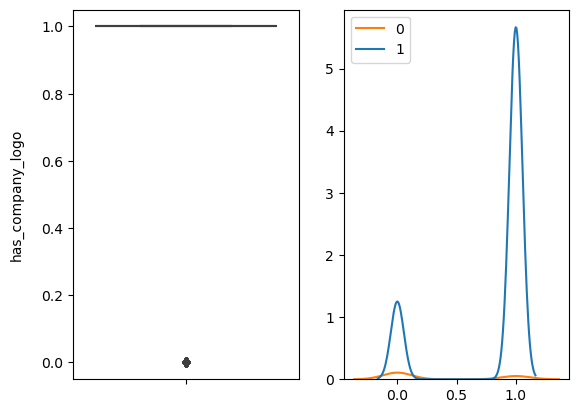

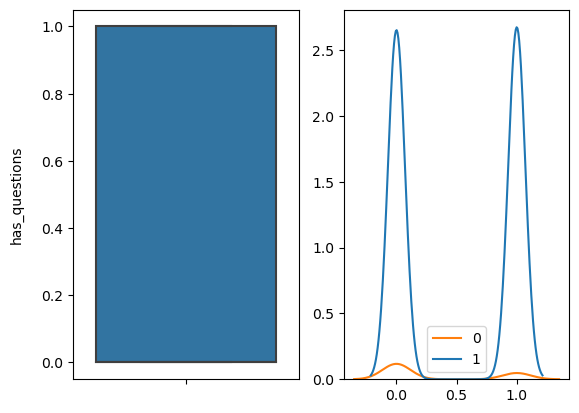

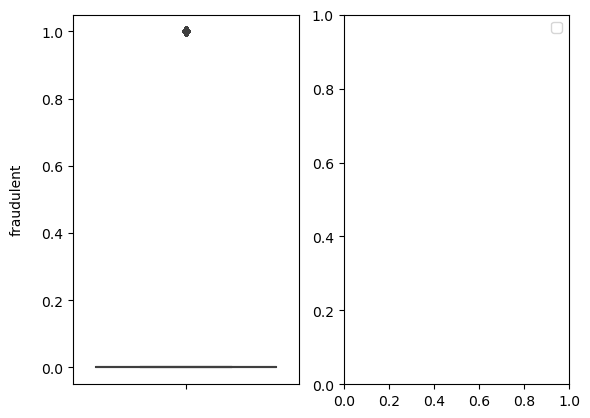

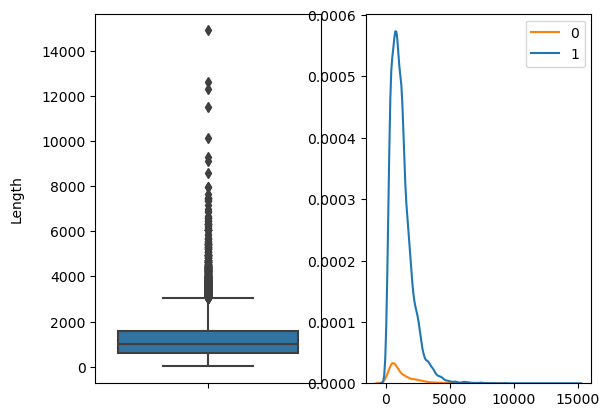

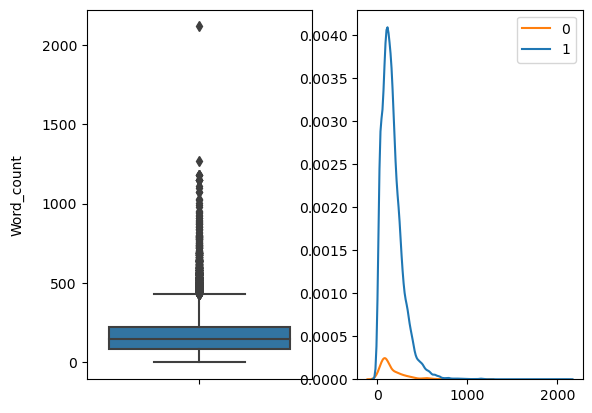

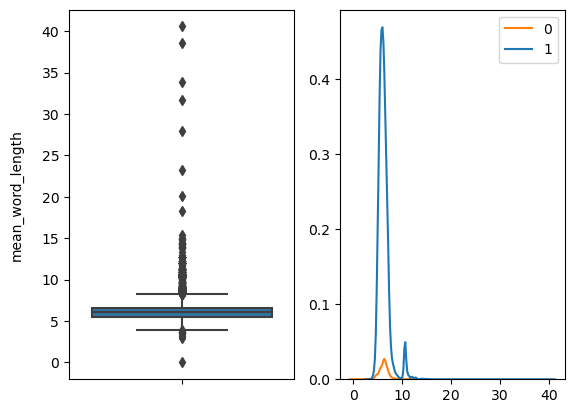

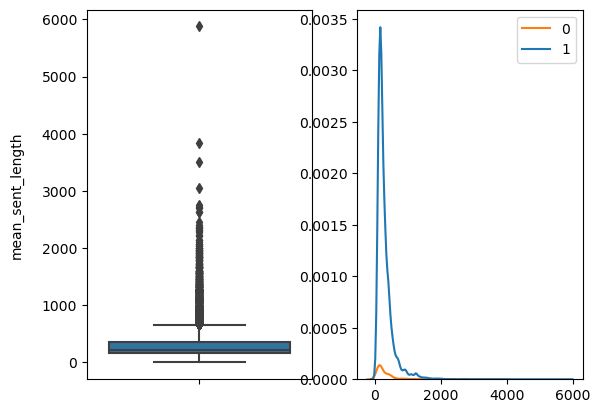

In [5]:
length = len(data['description'][0])
print(f'Length of a sample review: {length}')
data['Length'] = data['description'].str.len()

word_count = data['description'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

def word_count(review):
    if isinstance(review, str):
        company_profile_list = review.split()
        return len(company_profile_list)
    else:
        return 0

data['Word_count'] = data['description'].apply(word_count)
data['mean_word_length'] = data['description'].map(
    lambda rev: np.mean([len(word) for word in rev.split()]) if isinstance(rev, str) else 0
)
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['description'][0])])
data['mean_sent_length'] = data['description'].map(
    lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]) if isinstance(rev, str) else 0
)
data.head(10)

def visualize(col):
    print()
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], hue=data['fraudulent'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    
    # Melt data to long format for kdeplot
    melted_data = data.melt(id_vars='fraudulent', value_vars=[col], var_name='feature', value_name='value')
    sns.kdeplot(data=melted_data, x='value', hue='fraudulent')
    
    plt.legend(data['fraudulent'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

numeric_features = [col for col in data.columns.tolist()[2:] if data[col].dtype.kind in ('i', 'f')]
for feature in numeric_features:
    visualize(feature)

In [6]:
df = data.drop(numeric_features, axis=1)
def clean(review):
    if not isinstance(review, str):
        return ""

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review
df['description'] = df['description'].apply(clean)
df.head(10)
df['description'][0]
def corpus(text):
    text_list = text.split()
    return text_list
df['description'] = df['description'].apply(corpus)
df.head(10)

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","[food52, fast-growing, james, beard, award-win...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...","[organised, -, focused, -, vibrant, -, awesome...",What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"[client, located, houston, actively, seeking, ...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,"[company, esri, environmental, systems, resear...","EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,"[job, title, itemization, review, managerlocat...",QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider
5,Accounting Clerk,"US, MD,",NaN,NaN,NaN,"[job, overviewapex, environmental, consulting,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...","[responsibilitiesmanage, english-speaking, edi...",Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,Full-time,Mid-Senior level,Master's Degree,Online Media,Management
7,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,"[airenvyhey, seasoned, entrepreneurs, heart, s...","Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,NaN,NaN,NaN,NaN,NaN
8,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,"[implementationconfigurationtestingtraining, o...",MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,Full-time,Associate,NaN,Information Technology and Services,NaN
9,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...","[customer, service, associate, based, phoenix,...",Minimum Requirements:Minimum of 6 months custo...,NaN,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17880/17880 [00:00<00:00, 117603.03it/s]


Length of corpus: 1903262


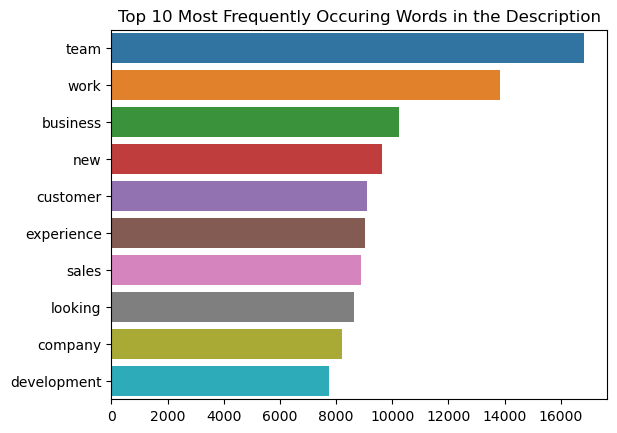

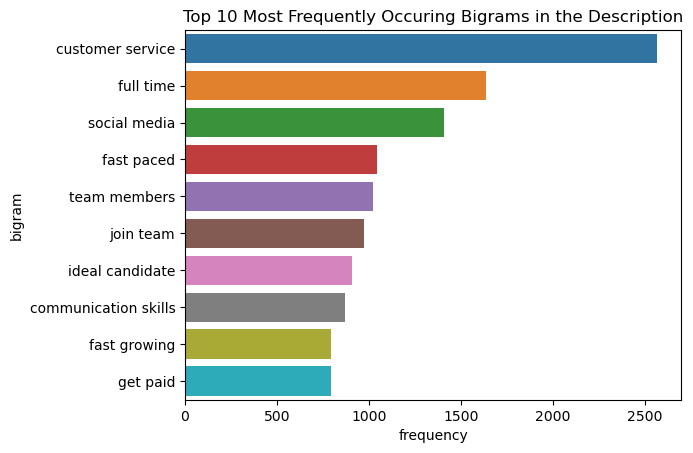

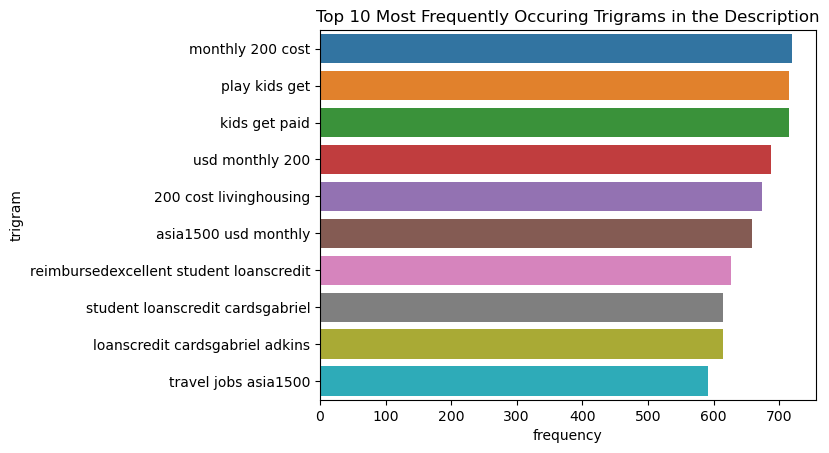

In [7]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['description'][i]
print(f"Length of corpus: {len(corpus)}")

mostCommon = Counter(corpus).most_common(10)
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words in the Description')
plt.show()

# Check if the data is already in the correct format, if not, convert it
if isinstance(df['description'].iloc[0], list):
    df['description'] = [' '.join(map(str, l)) for l in df['description']]

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['description'])
sum_bigrams = bigrams.sum(axis=0)
bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in cv.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key = lambda x: x[1], reverse=True)

# Now, plot the most common bigrams
bigrams_df = pd.DataFrame(bigrams_freq, columns=["bigram", "frequency"])
sns.barplot(x='frequency', y='bigram', data=bigrams_df.head(10))
plt.title('Top 10 Most Frequently Occuring Bigrams in the Description')
plt.show()

cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['description'])
sum_trigrams = trigrams.sum(axis=0)
trigrams_freq = [(word, sum_trigrams[0, idx]) for word, idx in cv1.vocabulary_.items()]
trigrams_freq = sorted(trigrams_freq, key = lambda x: x[1], reverse=True)

# Now, plot the most common trigrams
trigrams_df = pd.DataFrame(trigrams_freq, columns=["trigram", "frequency"])
sns.barplot(x='frequency', y='trigram', data=trigrams_df.head(10))
plt.title('Top 10 Most Frequently Occuring Trigrams in the Description')
plt.show()


requirements

Length of a sample review: 852
Word count in a sample review: 115


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


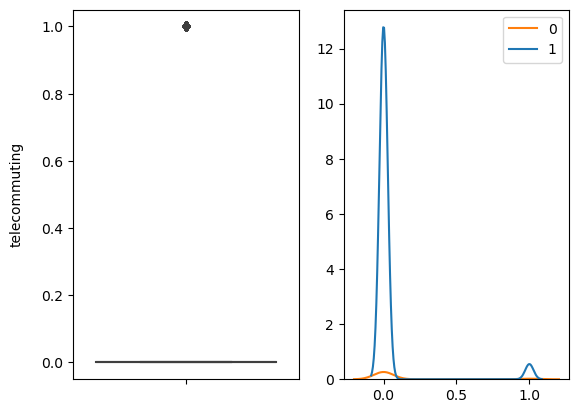

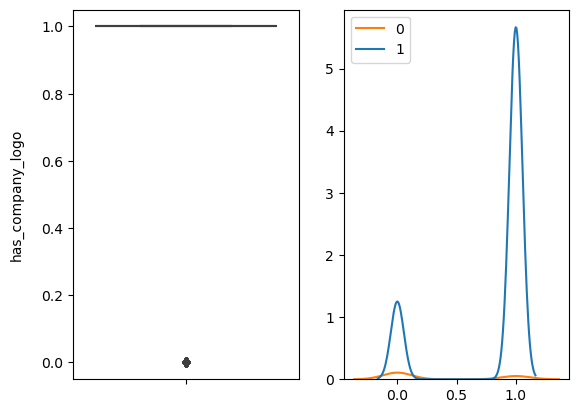

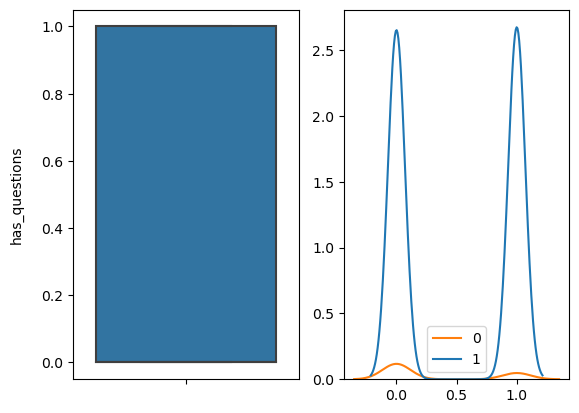

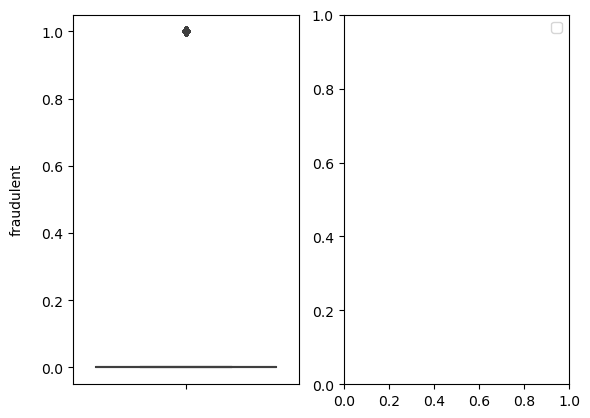

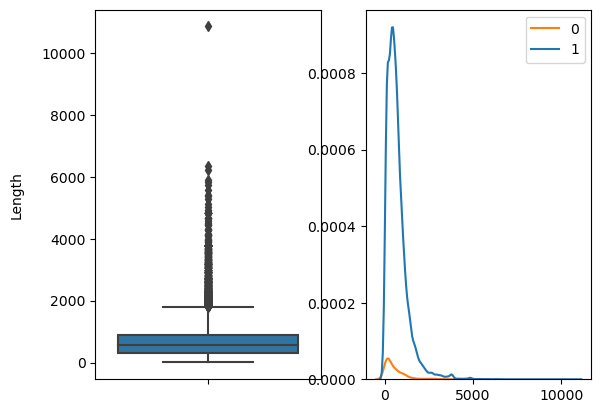

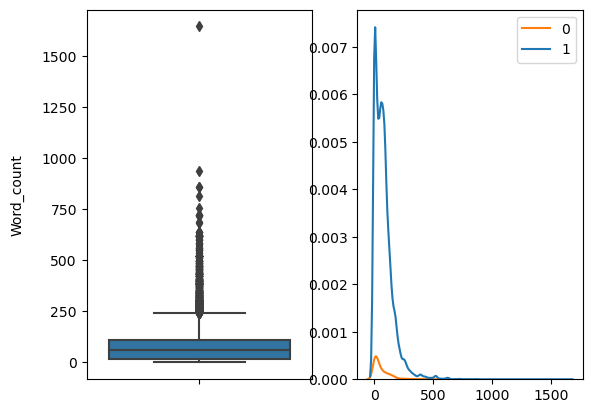

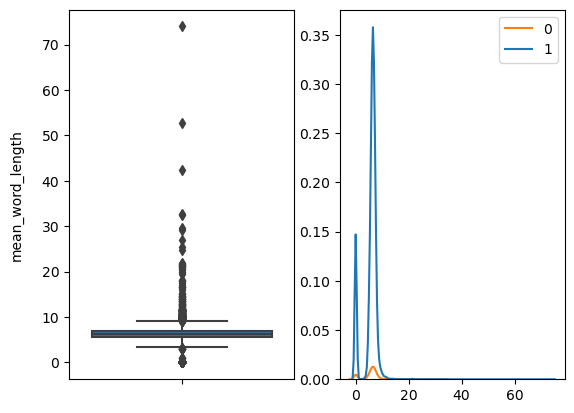

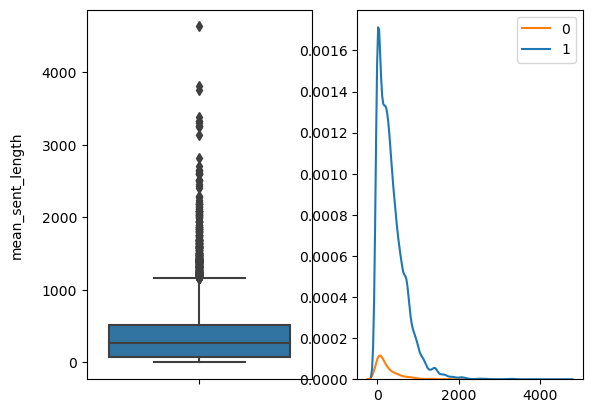

In [8]:
length = len(data['requirements'][0])
print(f'Length of a sample review: {length}')
data['Length'] = data['requirements'].str.len()

word_count = data['requirements'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

def word_count(review):
    if isinstance(review, str):
        company_profile_list = review.split()
        return len(company_profile_list)
    else:
        return 0

data['Word_count'] = data['requirements'].apply(word_count)
data['mean_word_length'] = data['requirements'].map(
    lambda rev: np.mean([len(word) for word in rev.split()]) if isinstance(rev, str) else 0
)
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['requirements'][0])])
data['mean_sent_length'] = data['requirements'].map(
    lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]) if isinstance(rev, str) else 0
)
data.head(10)

def visualize(col):
    print()
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], hue=data['fraudulent'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    
    # Melt data to long format for kdeplot
    melted_data = data.melt(id_vars='fraudulent', value_vars=[col], var_name='feature', value_name='value')
    sns.kdeplot(data=melted_data, x='value', hue='fraudulent')
    
    plt.legend(data['fraudulent'].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()

numeric_features = [col for col in data.columns.tolist()[2:] if data[col].dtype.kind in ('i', 'f')]
for feature in numeric_features:
    visualize(feature)

In [9]:
df = data.drop(numeric_features, axis=1)
def clean(review):
    if not isinstance(review, str):
        return ""

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review
df['requirements'] = df['requirements'].apply(clean)
df.head(10)
df['requirements'][0]
def corpus(text):
    text_list = text.split()
    return text_list
df['requirements'] = df['requirements'].apply(corpus)
df.head(10)

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...","[experience, content, management, systems, maj...",NaN,Other,Internship,NaN,NaN,Marketing
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,"[expect, youyour, key, responsibility, communi...",What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...","[implement, pre-commissioning, commissioning, ...",NaN,NaN,NaN,NaN,NaN,NaN
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"[educationbachelors, masters, gis, business, a...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,"[qualificationsrn, license, state, texasdiplom...",Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider
5,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,[],NaN,NaN,NaN,NaN,NaN,NaN
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,"[know-how, university, college, degree, journa...",Your Benefits: Being part of a fast-growing co...,Full-time,Mid-Senior level,Master's Degree,Online Media,Management
7,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"[experience, crm, software, live, chat, phones...",Competitive Pay. You'll be able to eat steak e...,NaN,NaN,NaN,NaN,NaN
8,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,"[must, us, citizenan, active, tssci, clearance...",NaN,Full-time,Associate,NaN,Information Technology and Services,NaN
9,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,"[minimum, requirementsminimum, 6, months, cust...",NaN,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17880/17880 [00:00<00:00, 134436.44it/s]


Length of corpus: 927063


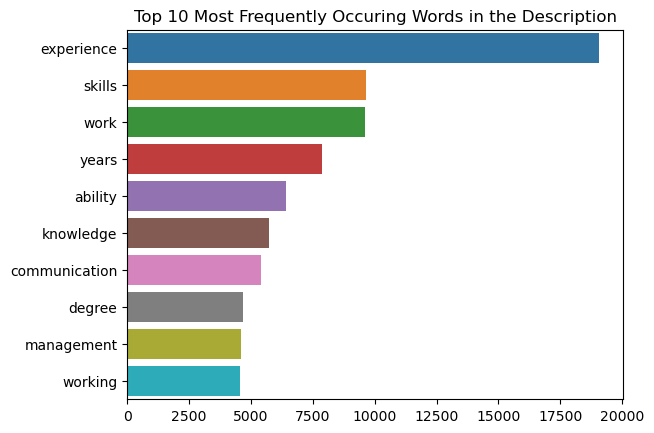

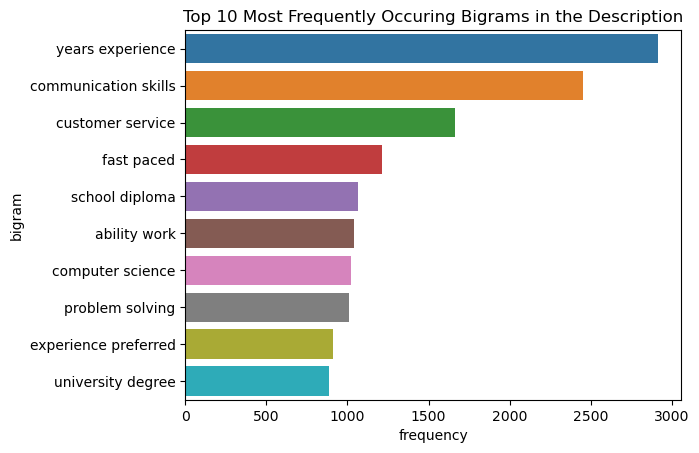

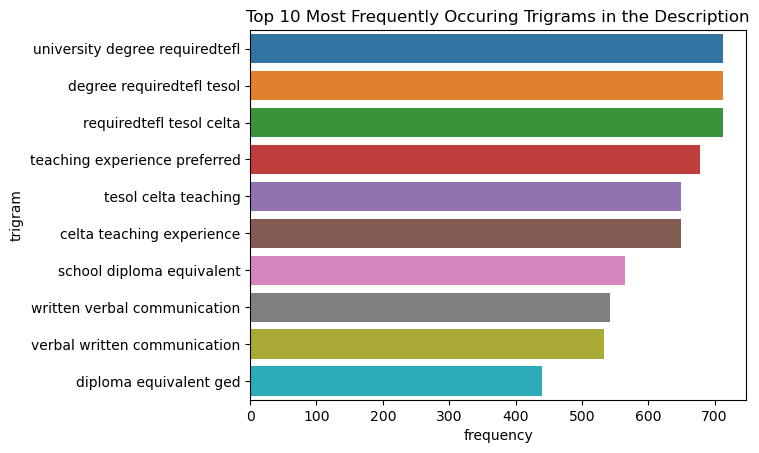

In [10]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['requirements'][i]
print(f"Length of corpus: {len(corpus)}")

mostCommon = Counter(corpus).most_common(10)
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words in the Description')
plt.show()

# Check if the data is already in the correct format, if not, convert it
if isinstance(df['requirements'].iloc[0], list):
    df['requirements'] = [' '.join(map(str, l)) for l in df['requirements']]

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['requirements'])
sum_bigrams = bigrams.sum(axis=0)
bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in cv.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key = lambda x: x[1], reverse=True)

# Now, plot the most common bigrams
bigrams_df = pd.DataFrame(bigrams_freq, columns=["bigram", "frequency"])
sns.barplot(x='frequency', y='bigram', data=bigrams_df.head(10))
plt.title('Top 10 Most Frequently Occuring Bigrams in the Description')
plt.show()

cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['requirements'])
sum_trigrams = trigrams.sum(axis=0)
trigrams_freq = [(word, sum_trigrams[0, idx]) for word, idx in cv1.vocabulary_.items()]
trigrams_freq = sorted(trigrams_freq, key = lambda x: x[1], reverse=True)

# Now, plot the most common trigrams
trigrams_df = pd.DataFrame(trigrams_freq, columns=["trigram", "frequency"])
sns.barplot(x='frequency', y='trigram', data=trigrams_df.head(10))
plt.title('Top 10 Most Frequently Occuring Trigrams in the Description')
plt.show()

benefits

Length of a sample review: 0
Word count in a sample review: 0


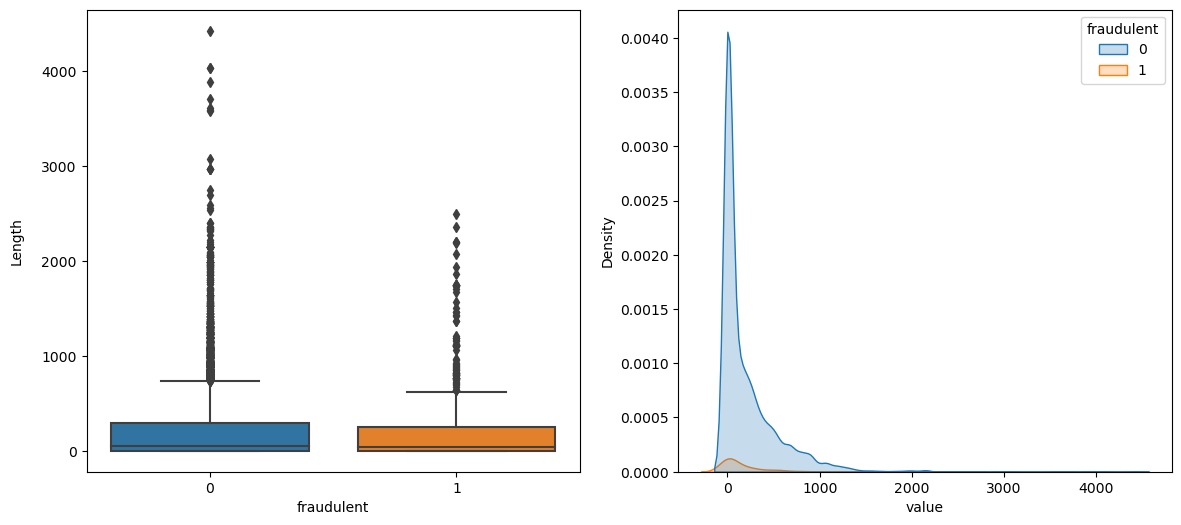

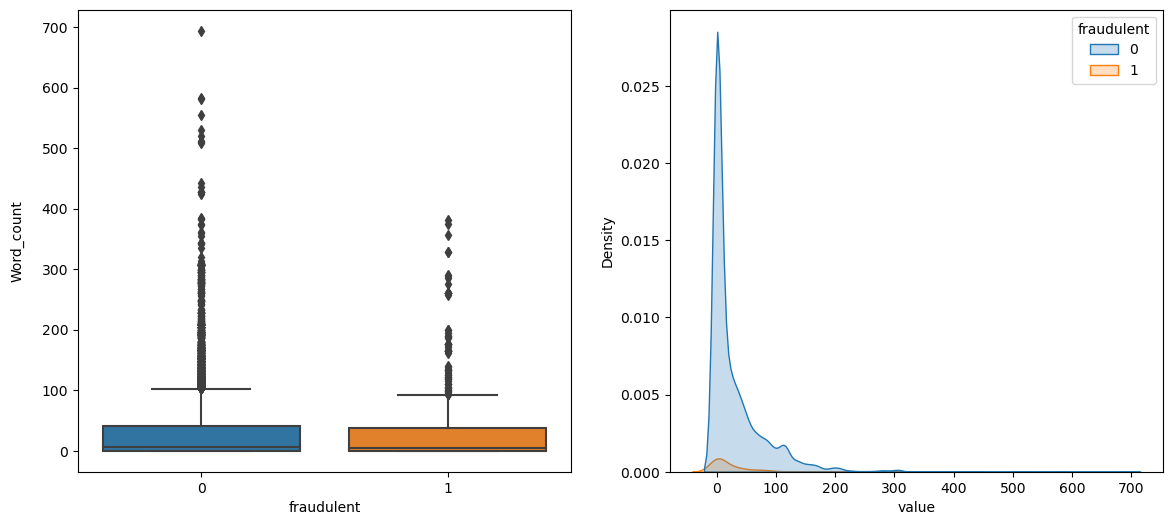

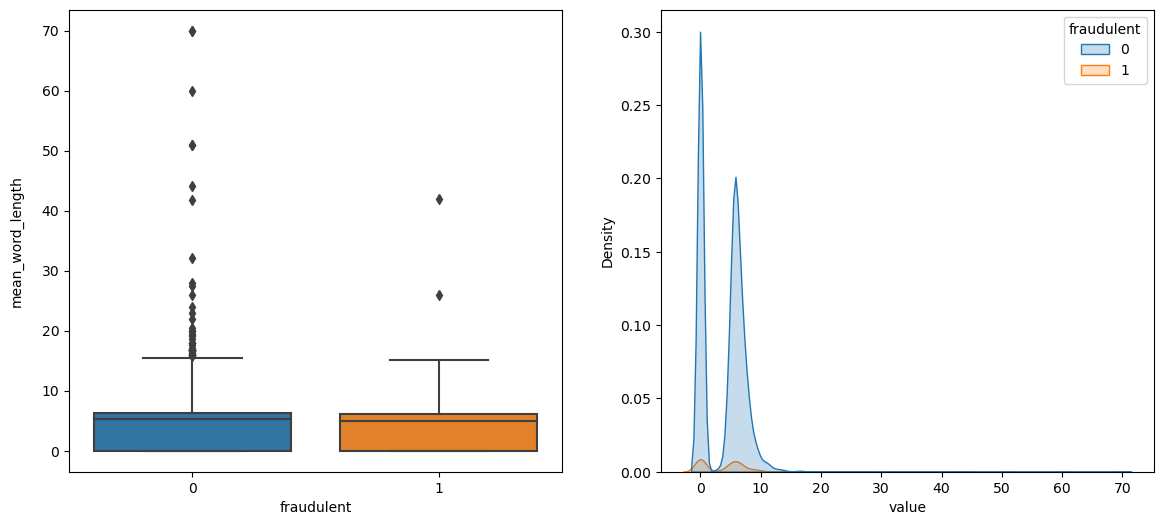

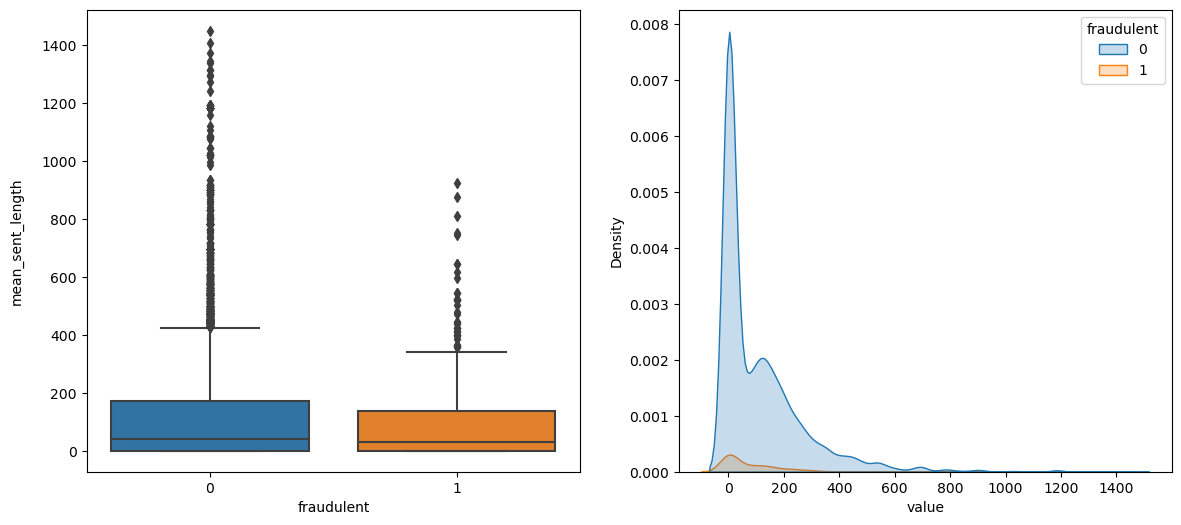

In [20]:
length = len(data['benefits'][0]) if isinstance(data['benefits'][0], str) else 0
print(f'Length of a sample review: {length}')

# Add a new column for length of each review
data['Length'] = data['benefits'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Word count in a sample review
word_count = data['benefits'][0].split() if isinstance(data['benefits'][0], str) else []
print(f'Word count in a sample review: {len(word_count)}')

# Function to calculate word count
def word_count(review):
    if isinstance(review, str):
        return len(review.split())
    else:
        return 0

# Add a new column for word count of each review
data['Word_count'] = data['benefits'].apply(word_count)

# Add a new column for mean word length of each review
data['mean_word_length'] = data['benefits'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if isinstance(x, str) and x.split() else 0
)

# Add a new column for mean sentence length of each review
data['mean_sent_length'] = data['benefits'].apply(
    lambda x: np.mean([len(sent) for sent in tokenize.sent_tokenize(x)]) if isinstance(x, str) and tokenize.sent_tokenize(x) else 0
)

# Function to visualize numeric features
def visualize(col):
    plt.figure(figsize=(14,6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data[col], x=data['fraudulent'])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1, 2, 2)
    melted_data = data.melt(id_vars='fraudulent', value_vars=[col], var_name='feature', value_name='value')
    sns.kdeplot(data=melted_data, x='value', hue='fraudulent', fill=True)
    
    plt.show()

# List of numeric features to visualize
numeric_features = ['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']

# Visualize each numeric feature
for feature in numeric_features:
    visualize(feature)

In [21]:
df = data.drop(numeric_features, axis=1)
def clean(review):
    if not isinstance(review, str):
        return ""

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])
    
    return review
df['benefits'] = df['benefits'].apply(clean)
df.head(10)
df['benefits'][0]
def corpus(text):
    text_list = text.split()
    return text_list
df['benefits'] = df['benefits'].apply(corpus)
df.head(10)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,[],0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,"[get, usthrough, part, 90, seconds, team, gain...",0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,[],0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...","[culture, anything, corporatewe, collaborative...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,"[full, benefits, offered]",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,[],0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,"[benefitsbeing, part, fast-growing, company, b...",0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...","[competitive, payyoull, able, eat, steak, ever...",0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,[],0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,[],0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 17880/17880 [00:00<00:00, 150201.30it/s]


Length of corpus: 342077


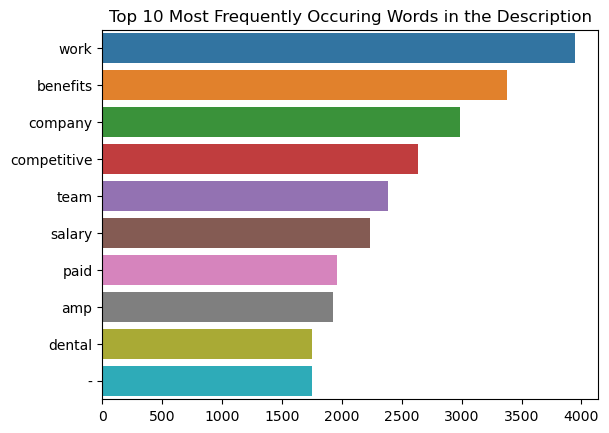

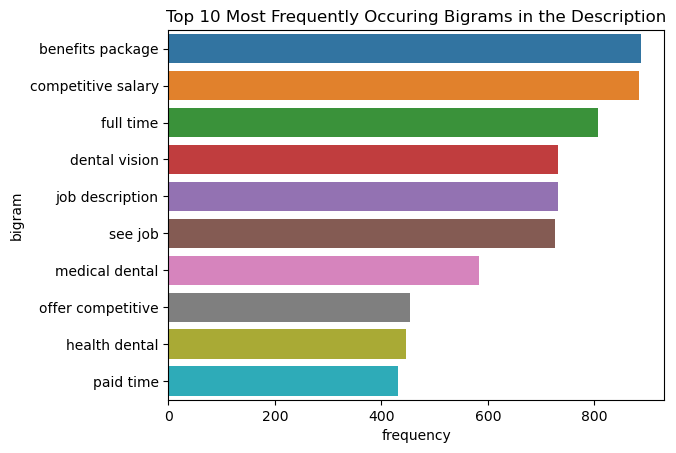

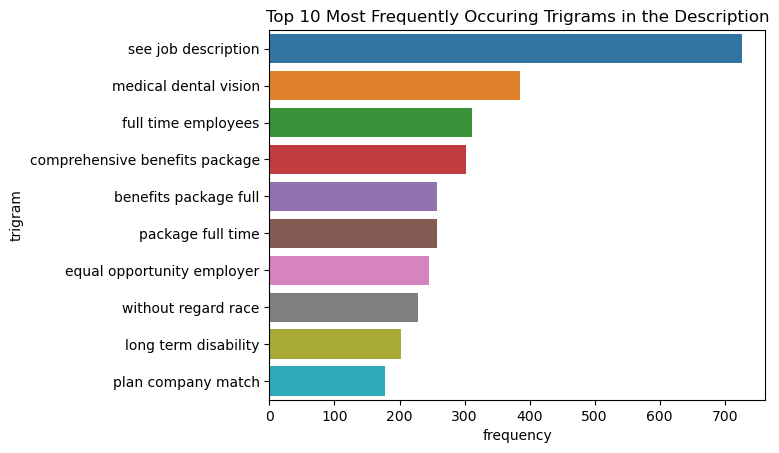

In [22]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['benefits'][i]
print(f"Length of corpus: {len(corpus)}")

mostCommon = Counter(corpus).most_common(10)
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words in the Description')
plt.show()

# Check if the data is already in the correct format, if not, convert it
if isinstance(df['benefits'].iloc[0], list):
    df['benefits'] = [' '.join(map(str, l)) for l in df['benefits']]

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['benefits'])
sum_bigrams = bigrams.sum(axis=0)
bigrams_freq = [(word, sum_bigrams[0, idx]) for word, idx in cv.vocabulary_.items()]
bigrams_freq = sorted(bigrams_freq, key = lambda x: x[1], reverse=True)

# Now, plot the most common bigrams
bigrams_df = pd.DataFrame(bigrams_freq, columns=["bigram", "frequency"])
sns.barplot(x='frequency', y='bigram', data=bigrams_df.head(10))
plt.title('Top 10 Most Frequently Occuring Bigrams in the Description')
plt.show()

cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['benefits'])
sum_trigrams = trigrams.sum(axis=0)
trigrams_freq = [(word, sum_trigrams[0, idx]) for word, idx in cv1.vocabulary_.items()]
trigrams_freq = sorted(trigrams_freq, key = lambda x: x[1], reverse=True)

# Now, plot the most common trigrams
trigrams_df = pd.DataFrame(trigrams_freq, columns=["trigram", "frequency"])
sns.barplot(x='frequency', y='trigram', data=trigrams_df.head(10))
plt.title('Top 10 Most Frequently Occuring Trigrams in the Description')
plt.show()

# Feature Extraction
Air is working on this, no need to worry about this section currently

In [5]:
# extract location
location  = data[['location']]

In [6]:
location.iloc[0].values.tolist()[0].split(', ')

['US', 'NY', 'New York']

In [7]:
# create column for country
country = []
for i in range(len(location)):
    if type(location.iloc[i].values[0]) == str:
        country.append(location.iloc[i].values[0].split(', ')[0])
    else:
        country.append('not provided')

In [8]:
country

['US',
 'NZ',
 'US',
 'US',
 'US',
 'US',
 'DE',
 'US',
 'US',
 'US',
 'US',
 'GB',
 'US',
 'US',
 'AU',
 'SG',
 'IL',
 'GB',
 'US',
 'US',
 'US',
 'NZ',
 'AE',
 'US',
 'GB',
 'US',
 'SG',
 'AE',
 'US',
 'CA',
 'US',
 'US',
 'US',
 'US',
 'GB',
 'US',
 'US',
 'US',
 'IN',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'EG',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'PL',
 'US',
 'CA',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'NZ',
 'GR',
 'US',
 'US',
 'US',
 'GB',
 'US',
 'US',
 'AE',
 'US',
 'DE',
 'US',
 'US',
 'US',
 'NZ',
 'US',
 'US',
 'GB',
 'US',
 'US',
 'US',
 'US',
 'US',
 'GR',
 'CA',
 'US',
 'GB',
 'US',
 'US',
 'GB',
 'US',
 'GB',
 'US',
 'US',
 'US',
 'US',
 'CA',
 'GB',
 'US',
 'US',
 'US',
 'GB',
 'GB',
 'US',
 'US',
 'US',
 'US',
 'US',
 'GB',
 'US',
 'GB',
 'US',
 'US',
 'US',
 'US',
 'US',
 'DE',
 'CA',
 'US',
 'US',
 'US',
 'GR',
 'US',
 'US',
 'US',
 'US',
 'GB',
 'GB',
 'US',
 'GB',
 'US',
 'US',
 'DE',
 'US',
 'US',
 'US',
 'US',
 'IL',

In [9]:
# append column to dataframe
data['country'] = country

In [10]:
loc_list = []
for i in range(len(location)):
    if type(location.iloc[i].values.tolist()[0]) == str:
        loc_list.append(location.iloc[i].values.tolist()[0].split(', '))
        
loc_list

[['US', 'NY', 'New York'],
 ['NZ', '', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', ''],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney'],
 ['SG', '01', 'Singapore'],
 ['IL', '', 'Tel Aviv', 'Israel'],
 ['GB', 'SOS', 'Southend-on-Sea'],
 ['US', 'NY', 'New York'],
 ['US', 'PA', 'USA Northeast'],
 ['US', 'TX', 'Austin'],
 ['NZ', 'N', 'Auckland'],
 ['AE', '', ''],
 ['US', 'CA', 'Carlsbad'],
 ['GB', 'LND', 'London'],
 ['US', 'NY', 'New York '],
 ['SG', '', ''],
 ['AE', 'AZ', 'Abudhabi'],
 ['US', 'MO', 'St. Louis'],
 ['CA', 'ON', 'Toronto'],
 ['US', 'MA', 'Waltham'],
 ['US', 'KS', ''],
 ['US', 'WA', 'Everett'],
 ['US', 'CA', 'San Ramon'],
 ['GB', 'LND', ''],
 ['US', 'NY', 'Saint Bonaventure'],
 ['US', 'NY', 'Yonkers'],
 ['US', 'TX', 'H

In [62]:
# working on this
# create column for city
city = []
for i in range(len(location)):
    if type(location.iloc[i].values[0]) == str:
        if location.iloc[i].values[0].split(',')[-1] == ' ':
            if len(location.iloc[i].values[0].split(', ')[-2].strip()) > 2:
                city.append(location.iloc[i].values[0].split(', ')[-2])
            else:
                city.append('not provided')
        else:
            city.append(location.iloc[i].values[0].split(', ')[-1])
    else:
        city.append('not provided')

In [11]:
location.iloc[42]

location    US
Name: 42, dtype: object

In [64]:
city.index('US')

42

In [37]:
location.iloc[144].values[0]

nan

In [32]:
location.iloc[3].values[0].split(',')[0]

'US'

# Preprocessing

# Modeling